In [7]:
# Importing packages
import os
import cv2
import numpy as np
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import gradio as gr

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# Paths
input_dir = "/kaggle/working/train/images/"  # Directory with original images
output_dir = "/kaggle/working/segmented_masked_images"  # Directory where segmented masks will be saved

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [9]:
# Function to segment an image (you can modify this function to use other segmentation methods)
def segment_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold to create a binary mask
    _, binary_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    return binary_mask

In [10]:
# Loop over all images in the input directory
for image_name in os.listdir(input_dir):
    image_path = os.path.join(input_dir, image_name)

    # Read the image
    image = io.imread(image_path)

    # Segment the image
    segmented_mask = segment_image(image)

    # Save the segmented mask
    output_path = os.path.join(output_dir, image_name)
    cv2.imwrite(output_path, segmented_mask)
print(f"Segmented masks saved in {output_dir}")

Segmented masks saved in /kaggle/working/segmented_masked_images


In [12]:
# Assigning Paths
train_images_dir = '/kaggle/working/train/images/'
train_masks_dir = '/kaggle/working/segmented_masked_images/'

In [14]:
# Function to load images and masks, and resize them to the desired shape
def load_images_and_masks(train_images_dir, train_masks_dir, target_size=(256, 256)):
    images = []
    masks = []

    for image_name in os.listdir(train_images_dir):
        image_path = os.path.join(train_images_dir, image_name)
        mask_path = os.path.join(train_masks_dir, image_name)

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image and mask to the target size
        image = cv2.resize(image, target_size)
        mask = cv2.resize(mask, target_size)

        # Normalize images and masks
        image = image / 255.0
        mask = mask / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [15]:
# Load training data with resized images
X_train, y_train = load_images_and_masks(train_images_dir, train_masks_dir, target_size=(256, 256))

# Expand dimensions of masks to match the expected shape of the model (batch, height, width, channels)
y_train = np.expand_dims(y_train, axis=-1)

print("Loading Complete")

Loading Complete


In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (5598, 256, 256, 3)
y_train shape: (5598, 256, 256, 1)


In [17]:
# U-Net architecture
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [18]:
# Create the model
input_shape = (256, 256, 3)  # Adjust based on your image dimensions
model = unet_model(input_shape)

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        131,200 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 64)   │         32,832 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 128)  │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │         73,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

# Train the model with early stopping & store history
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,  
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 244s 737ms/step - accuracy: 0.9197 - loss: 0.2148 - val_accuracy: 0.9558 - val_loss: 0.0568
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 159s 569ms/step - accuracy: 0.9571 - loss: 0.0539 - val_accuracy: 0.9489 - val_loss: 0.0707
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 159s 567ms/step - accuracy: 0.9590 - loss: 0.0490 - val_accuracy: 0.9626 - val_loss: 0.0376
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 159s 566ms/step - accuracy: 0.9615 - loss: 0.0423 - val_accuracy: 0.9582 - val_loss: 0.0479
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 159s 567ms/step - accuracy: 0.9645 - loss: 0.0357 - val_accuracy: 0.9629 - val_loss: 0.0359
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 156s 556ms/step - accuracy: 0.9627 - loss: 0.0375 - val_accuracy: 0.9632 - val_loss: 0.0350
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 153s 548ms/step - accuracy: 0.9644 - loss: 0.0342 - val_accuracy: 0.9626 - val_loss: 0.0369
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 153s 546ms/step - accuracy: 0.9643 -

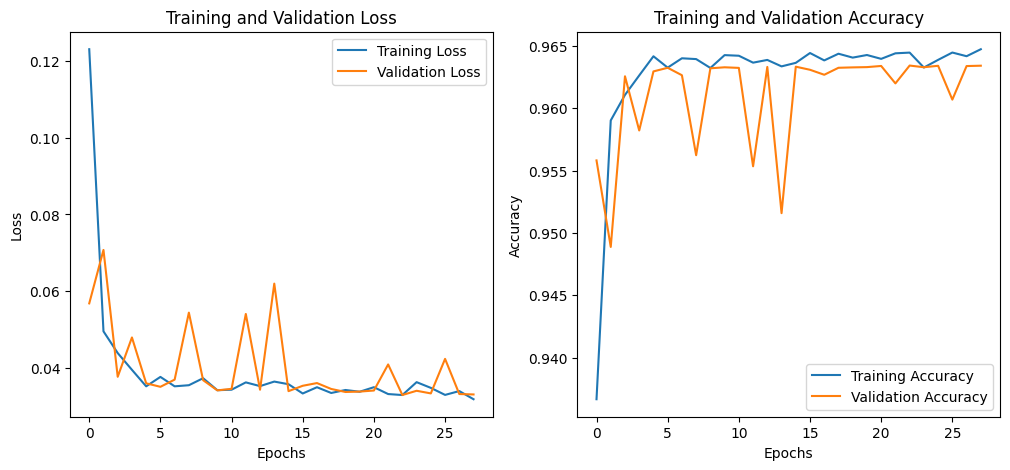

In [21]:
# Extract training history
history_dict = history.history  

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [22]:
# Save as a Keras model (Native Keras format)
model.save('Building_Detection_And_Counting_And_Population_Estimation_Model.keras')

# Save as a .h5 file (HDF5 format), explicitly including the optimizer
model.save('Building_Detection_And_Counting_And_Population_Estimation_Model.h5', include_optimizer=True)

# Export as TensorFlow SavedModel format (directory format)
model.export('Building_Detection_And_Counting_And_Population_Estimation_Model')

Saved artifact at 'Building_Detection_And_Counting_And_Population_Estimation_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  134722820143616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818729488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818734944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818729664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818720688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818725616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818731600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722818734416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134724547809472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134724547810704: TensorSpec

In [23]:
# Load the pre-trained U-Net model
model = load_model('/kaggle/working/Building_Detection_And_Counting_And_Population_Estimation_Model.h5')

# Function to preprocess the input image
def preprocess_image(image, target_size=(256, 256)):
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to estimate population based on building count
def estimate_population(building_count, people_per_building=5):
    return building_count * people_per_building

# Function to post-process and count buildings
def postprocess_and_count(mask):
    # Threshold the mask to create a binary image
    binary_mask = mask > 0.5

    # Label connected regions (buildings)
    labeled_mask, num_buildings = label(binary_mask, return_num=True)

    return labeled_mask, num_buildings

# Function to draw boundaries around detected buildings
def draw_building_boundaries(image, labeled_mask):
    contours, _ = cv2.findContours((labeled_mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined_image = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)
    return outlined_image

# Function to detect buildings, estimate population, and draw boundaries
def detect_buildings(image):
    # Preprocess the image for the model
    input_image = preprocess_image(image)

    # Predict the mask using the model
    predicted_mask = model.predict(input_image)[0, :, :, 0]

    # Post-process the mask and count the buildings
    labeled_mask, num_buildings = postprocess_and_count(predicted_mask)

    # Estimate the population based on building count
    estimated_population = estimate_population(num_buildings)

    # Draw boundaries around detected buildings
    outlined_image = draw_building_boundaries(cv2.resize(image, (256, 256)), labeled_mask)

    # Convert labeled mask back to RGB for visualization
    labeled_mask_rgb = cv2.cvtColor((labeled_mask > 0).astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)

    return outlined_image, f"Number of buildings detected: {num_buildings}", f"Estimated population: {estimated_population}"

# Gradio interface
gr_interface = gr.Interface(
    fn=detect_buildings,
    inputs=gr.Image(type="numpy"),
    outputs=[
        gr.Image(type="numpy", label="Building Segmentation with Boundaries"),
        gr.Textbox(label="Building Count"),
        gr.Textbox(label="Estimated Population")
    ],
    title="Building Detection, Counting, and Population Estimation",
    description="Upload a satellite image to detect, count buildings, and estimate population based on building count.",
)

# Launch the Gradio interface
gr_interface.launch(share=True, show_error=True, debug=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://28d2f0acf42522cc2d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://28d2f0acf42522cc2d.gradio.live
